CRIM: 城镇人均犯罪率                                                          AGE: 1940年之前建成的自用房屋比例

ZN：住宅用地超过 25000 sq.ft. 的比例                             DIS：到波士顿5个中心区域的加权距离

INDUS: 城镇非零售商用土地的比例                                    RAD: 辐射性公路的靠近指数

CHAS: 边界是河流为1，否则0                                            TAX: 每10000美元的全值财产税率

NOX: 一氧化氮浓度                                                               PTRATIO: 城镇师生比例         

RM: 住宅平均房间数                                                             LSTAT: 人口中地位低下者的比例
                                                                                                 MEDV: 自住房的平均房价，单位：千美元

# 数据读取

## 导入相关库

In [3]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle


## 通过Pandas导入数据

In [4]:
# 读取数据文件

df = pd.read_csv("data/boston.csv", header=0)

#显示数据摘要描述信息

print (df.describe())

             CRIM         ZN       INDUS         CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO       LSTAT  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534   12.653063   
std     28.148861    2.1057

## 载入本示例所需数据

In [6]:
# 获取df的值
df = df.values
print(df.shape)

(506, 13)


## 特征数据归一化

In [7]:
# 对特征数据 【0到11】列 做（0-1）归一化
for i in range(12):
    df[:,i]=df[:,i]/(df[:,i].max()-df[:,i].min())
    
# x_data 为 归一化后的前12列特征数据
x_data = df[:,:12] 

# y_data 为最后1列标签数据
y_data = df[:,12]

In [8]:
print("x_data shape=", x_data.shape)
print("y_data shape=", y_data.shape)


x_data shape= (506, 12)
y_data shape= (506,)


In [9]:
# 划分数据集
train_num = 300  # 训练集数目
valid_num = 100  # 验证集数目
test_num = len(x_data) - train_num - valid_num  # 测试集数目  506 - 训练集 - 验证集

# 训练集划分 列表中的0-300的元素
x_train = x_data[:train_num]
y_train = y_data[:train_num]

# 验证集划分 列表中的300-400的元素
x_valid = x_data[train_num : train_num + valid_num]
y_valid = y_data[train_num : train_num + valid_num]

# 测试集划分 列表中的400 - 506的元素
x_test = x_data[train_num + valid_num : train_num + valid_num + test_num]
y_test = y_data[train_num + valid_num : train_num + valid_num + test_num]


In [14]:
x_train = tf.cast(x_train, dtype=tf.float32)
x_valid = tf.cast(x_valid, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

# 构建模型

In [15]:
# 创建待优化变量
# random.normal([12,1] 生成数据 mean 是平均数，stddev 是标准差 生成了一个 12 行 1 列 的二维数组
W = tf.Variable(tf.random.normal([12, 1], mean=0.0, stddev=1.0, dtype=tf.float32))
# zeros 函数生成 了一维的张量，里面的值是 0
B = tf.Variable(tf.zeros(1), dtype=tf.float32)


In [24]:
# 构建模型
# 定义模型函数
def model(x, w, b):
    return tf.matmul(x, w) + b


# 定义均方误差损失函数
def loss(x, y, w, b):
    err = model(x, w, b) - y
    squared_err = tf.square(err)
    return tf.reduce_mean(squared_err)


# 定义梯度计算函数
# 计算样本数据[x,y]在参数[w,b]点上的梯度


def grad(x, y, w, b):
    with tf.GradientTape() as tape:
        loss_ = loss(x, y, w, b)
    return tape.gradient(loss_, [w, b])  # 返回梯度向量


# 定义模型的各种参数
training_epochs = 500  # 迭代次数
learning_rate = 0.001  # 学习率

batch_size = 10  # 批量训练一次的样本数

optimizer = tf.keras.optimizers.SGD(learning_rate)  # 创建优化器，指定学习率


# 训练模型

In [25]:
loss_list_train = []  # 用于保存训练集loss值的列表
loss_list_valid = []  # 用于保存验证集loss值的列表
total_step = int(train_num / batch_size)

for epoch in range(training_epochs):
    for step in range(total_step):
        xs = x_train[step * batch_size : (step + 1) * batch_size, :]
        # 对x_train（300*12）依次存入第0-10，10-20行......数据

        ys = y_train[step * batch_size : (step + 1) * batch_size]  #  对y_train（300*1）

        grads = grad(xs, ys, W, B)  # 计算梯度
        optimizer.apply_gradients(zip(grads, [W, B]))  # 优化器根据梯度自动调整变量 W和B

    loss_train = loss(x_train, y_train, W, B).numpy()  # 计算当前轮训练损失
    loss_valid = loss(x_valid, y_valid, W, B).numpy()  # 计算当前轮验证损失
    loss_list_train.append(loss_train)
    loss_list_valid.append(loss_valid)

    print(
        "epoch={:3d}, train_loss={:.4f}, valid_loss = {:.4f}".format(
            epoch + 1, loss_train, loss_valid
        )
    )


epoch=  1, train_loss=80.9320, valid_loss = 119.5794
epoch=  2, train_loss=80.9737, valid_loss = 119.4602
epoch=  3, train_loss=81.0161, valid_loss = 119.3434
epoch=  4, train_loss=81.0591, valid_loss = 119.2288
epoch=  5, train_loss=81.1027, valid_loss = 119.1165
epoch=  6, train_loss=81.1468, valid_loss = 119.0064
epoch=  7, train_loss=81.1914, valid_loss = 118.8985
epoch=  8, train_loss=81.2366, valid_loss = 118.7927
epoch=  9, train_loss=81.2822, valid_loss = 118.6889
epoch= 10, train_loss=81.3283, valid_loss = 118.5872
epoch= 11, train_loss=81.3749, valid_loss = 118.4875
epoch= 12, train_loss=81.4219, valid_loss = 118.3897
epoch= 13, train_loss=81.4693, valid_loss = 118.2938
epoch= 14, train_loss=81.5171, valid_loss = 118.1998
epoch= 15, train_loss=81.5653, valid_loss = 118.1075
epoch= 16, train_loss=81.6138, valid_loss = 118.0170
epoch= 17, train_loss=81.6627, valid_loss = 117.9283
epoch= 18, train_loss=81.7119, valid_loss = 117.8413
epoch= 19, train_loss=81.7615, valid_loss = 11

## 可视化训练过程中的损失值

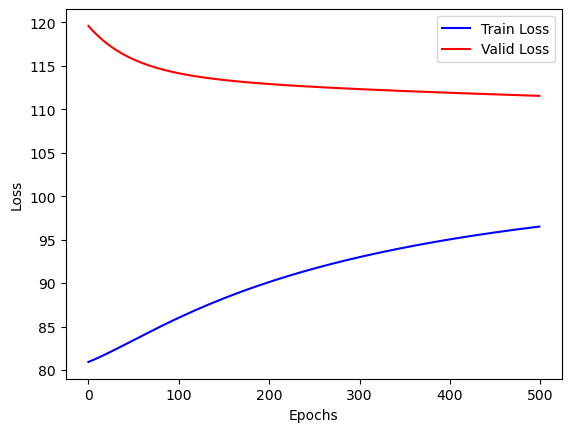

In [26]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_list_train, "blue", label="Train Loss")
plt.plot(loss_list_valid, "red", label="Valid Loss")
plt.legend(loc=1)  # 通过参数loc指定图例位置


In [27]:
print("Test_loss:{:.4f}".format(loss(x_test, y_test, W, B).numpy()))


Test_loss:80.6697


In [29]:
test_house_id = np.random.randint(0, test_num)
y = y_test[test_house_id]
y_pred = model(x_test, W, B)[test_house_id]
y_predict = tf.reshape(y_pred, ()).numpy()
print("House id:", test_house_id, "\nActual value:", y, "\nPredicted value:", y_predict)


House id: 69 
Actual value: 20.1 
Predicted value: 21.650038
